# Comparison Between TreeValue and Tianshou Batch

In this section, we will take a look at the feature and performance of the [Tianshou Batch](https://github.com/thu-ml/tianshou) library, which is developed by Tsinghua Machine Learning Group.

Before starting the comparison, let us define some thing.

In [1]:
import torch 

_TREE_DATA_1 = {'a': 1, 'b': 2, 'x': {'c': 3, 'd': 4}}
_TREE_DATA_2 = {
    'a': torch.randn(2, 3), 
    'x': {
        'c': torch.randn(3, 4)
    },
}
_TREE_DATA_3 = {
    'obs': torch.randn(4, 84, 84),
    'action': torch.randint(0, 6, size=(1,)),
    'reward': torch.rand(1),
}

## Read and Write Operation

Reading and writing are the two most common operations in the tree data structure based on the data model (TreeValue and Tianshou Batch both belong to this type), so this section will compare the reading and writing performance of these two libraries.

### TreeValue's Get and Set

In [2]:
from treevalue import FastTreeValue

t = FastTreeValue(_TREE_DATA_2)

/home/runner/work/treevalue/treevalue/treevalue/tree/integration/torch.py:23: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  register_for_torch(TreeValue)
/home/runner/work/treevalue/treevalue/treevalue/tree/integration/torch.py:24: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  register_for_torch(FastTreeValue)


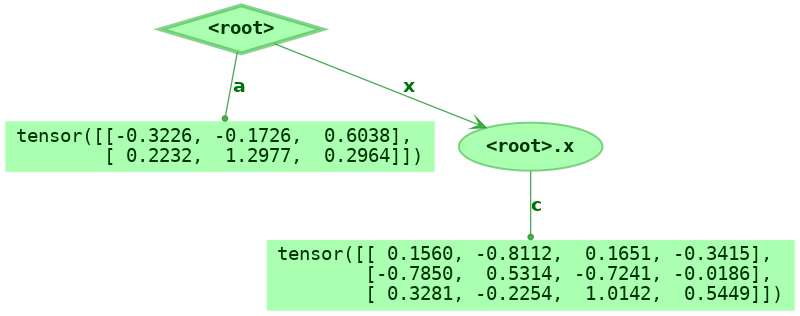

In [3]:
t

In [4]:
t.a

tensor([[-0.3226, -0.1726,  0.6038],
        [ 0.2232,  1.2977,  0.2964]])

In [5]:
%timeit t.a

45.5 ns ± 0.179 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


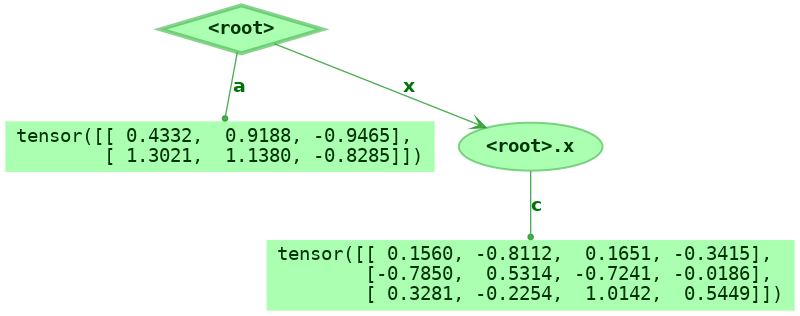

In [6]:
new_value = torch.randn(2, 3)
t.a = new_value

t

In [7]:
%timeit t.a = new_value

51.8 ns ± 0.0946 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


### Tianshou Batch's Get and Set

In [8]:
from tianshou.data import Batch

b = Batch(**_TREE_DATA_2)

In [9]:
b

Batch(
    a: tensor([[-0.3226, -0.1726,  0.6038],
               [ 0.2232,  1.2977,  0.2964]]),
    x: Batch(
           c: tensor([[ 0.1560, -0.8112,  0.1651, -0.3415],
                      [-0.7850,  0.5314, -0.7241, -0.0186],
                      [ 0.3281, -0.2254,  1.0142,  0.5449]]),
       ),
)

In [10]:
b.a

tensor([[-0.3226, -0.1726,  0.6038],
        [ 0.2232,  1.2977,  0.2964]])

In [11]:
%timeit b.a

43.4 ns ± 0.353 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [12]:
new_value = torch.randn(2, 3)
b.a = new_value

b

Batch(
    a: tensor([[ 2.4838,  0.2505, -0.3832],
               [-1.1766, -1.2763, -1.7030]]),
    x: Batch(
           c: tensor([[ 0.1560, -0.8112,  0.1651, -0.3415],
                      [-0.7850,  0.5314, -0.7241, -0.0186],
                      [ 0.3281, -0.2254,  1.0142,  0.5449]]),
       ),
)

In [13]:
%timeit b.a = new_value

364 ns ± 2.69 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


## Initialization

### TreeValue's Initialization

In [14]:
%timeit FastTreeValue(_TREE_DATA_1)

6.72 µs ± 51.1 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


### Tianshou Batch's Initialization

In [15]:
%timeit Batch(**_TREE_DATA_1)

8.49 µs ± 51.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


## Deep Copy Operation

In [16]:
import copy

### Deep Copy of TreeValue

In [17]:
t3 = FastTreeValue(_TREE_DATA_3)
%timeit copy.deepcopy(t3)

127 µs ± 456 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### Deep Copy of Tianshou Batch

In [18]:
b3 = Batch(**_TREE_DATA_3)
%timeit copy.deepcopy(b3)

125 µs ± 616 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Stack, Concat and Split Operation

### Performance of TreeValue

In [19]:
trees = [FastTreeValue(_TREE_DATA_2) for _ in range(8)]

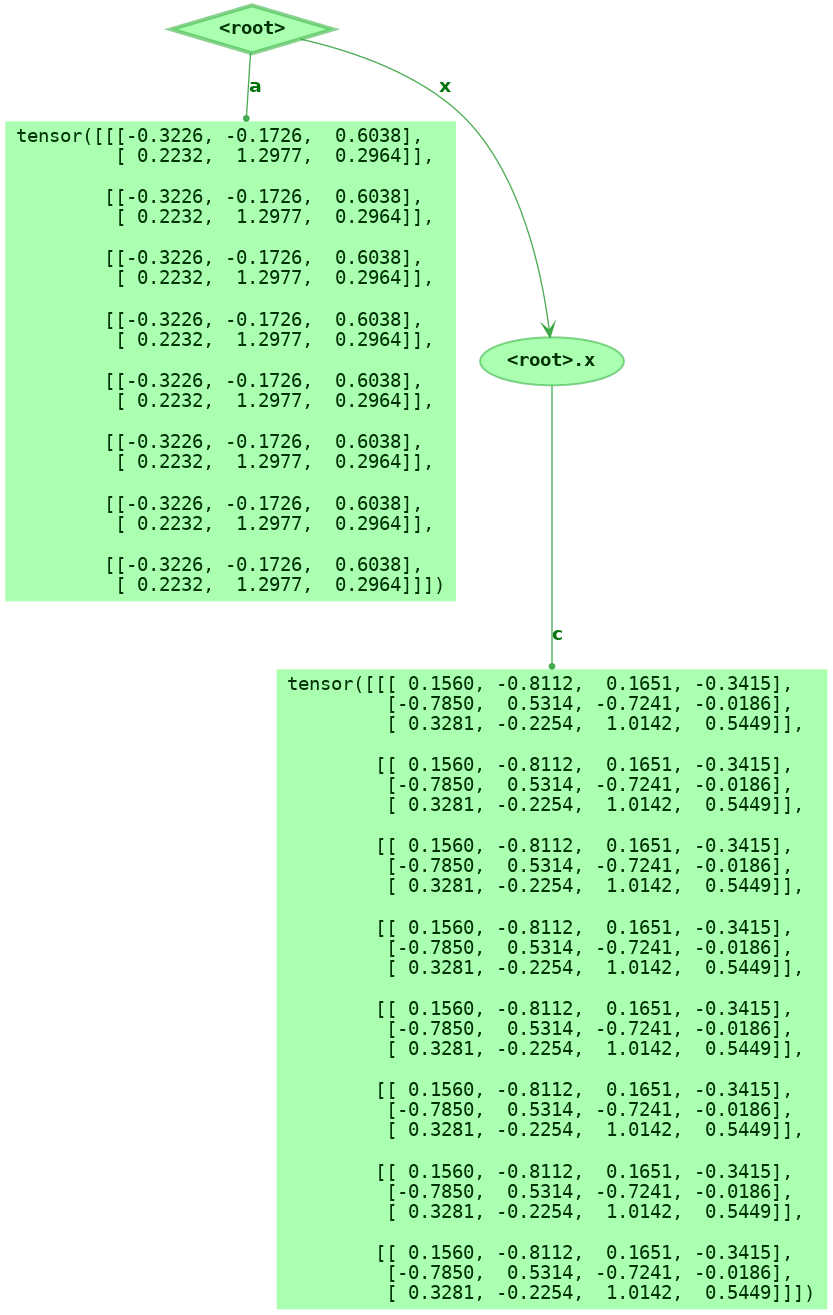

In [20]:
t_stack = FastTreeValue.func(subside=True)(torch.stack)

t_stack(trees)

In [21]:
%timeit t_stack(trees)

24.3 µs ± 266 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


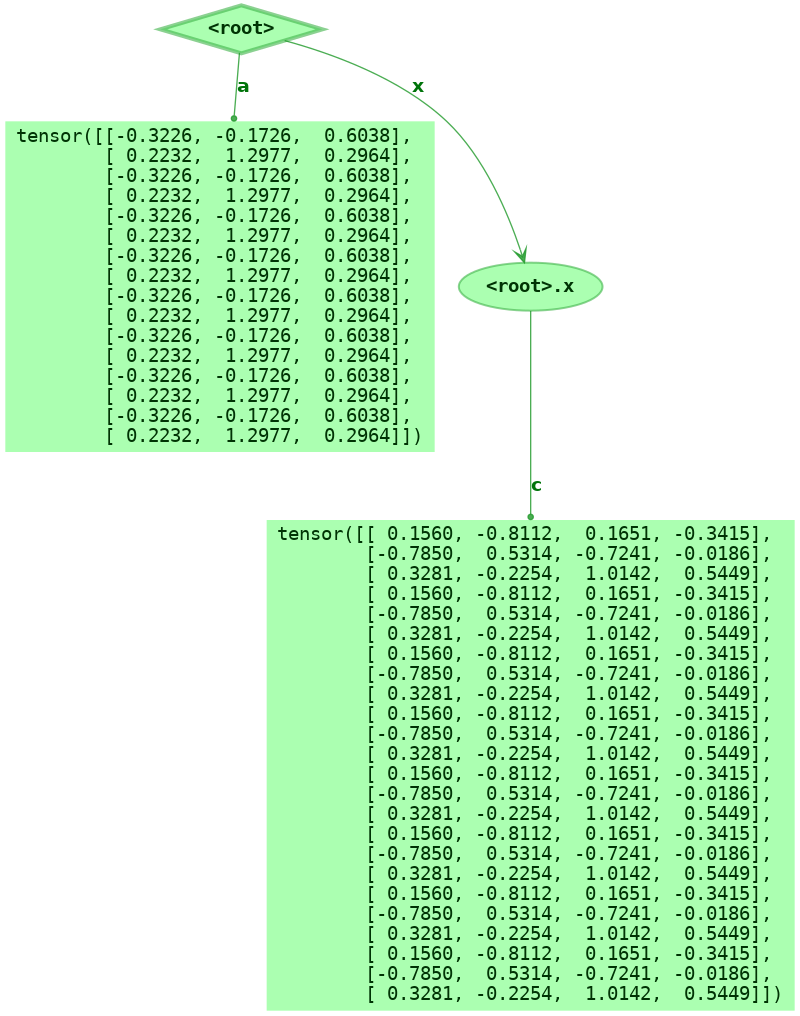

In [22]:
t_cat = FastTreeValue.func(subside=True)(torch.cat)

t_cat(trees)

In [23]:
%timeit t_cat(trees)

22.6 µs ± 258 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [24]:
t_split = FastTreeValue.func(rise=True)(torch.split)
tree = FastTreeValue({
    'obs': torch.randn(8, 4, 84, 84),
    'action': torch.randint(0, 6, size=(8, 1,)),
    'reward': torch.rand(8, 1),
})

%timeit t_split(tree, 1)

50.5 µs ± 283 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### Performance of Tianshou Batch

In [25]:
batches = [Batch(**_TREE_DATA_2) for _ in range(8)]

Batch.stack(batches)

Batch(
    a: tensor([[[-0.3226, -0.1726,  0.6038],
                [ 0.2232,  1.2977,  0.2964]],
       
               [[-0.3226, -0.1726,  0.6038],
                [ 0.2232,  1.2977,  0.2964]],
       
               [[-0.3226, -0.1726,  0.6038],
                [ 0.2232,  1.2977,  0.2964]],
       
               [[-0.3226, -0.1726,  0.6038],
                [ 0.2232,  1.2977,  0.2964]],
       
               [[-0.3226, -0.1726,  0.6038],
                [ 0.2232,  1.2977,  0.2964]],
       
               [[-0.3226, -0.1726,  0.6038],
                [ 0.2232,  1.2977,  0.2964]],
       
               [[-0.3226, -0.1726,  0.6038],
                [ 0.2232,  1.2977,  0.2964]],
       
               [[-0.3226, -0.1726,  0.6038],
                [ 0.2232,  1.2977,  0.2964]]]),
    x: Batch(
           c: tensor([[[ 0.1560, -0.8112,  0.1651, -0.3415],
                       [-0.7850,  0.5314, -0.7241, -0.0186],
                       [ 0.3281, -0.2254,  1.0142,  0.5449]],
         

In [26]:
%timeit Batch.stack(batches)

62.8 µs ± 1.68 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [27]:
Batch.cat(batches)

Batch(
    a: tensor([[-0.3226, -0.1726,  0.6038],
               [ 0.2232,  1.2977,  0.2964],
               [-0.3226, -0.1726,  0.6038],
               [ 0.2232,  1.2977,  0.2964],
               [-0.3226, -0.1726,  0.6038],
               [ 0.2232,  1.2977,  0.2964],
               [-0.3226, -0.1726,  0.6038],
               [ 0.2232,  1.2977,  0.2964],
               [-0.3226, -0.1726,  0.6038],
               [ 0.2232,  1.2977,  0.2964],
               [-0.3226, -0.1726,  0.6038],
               [ 0.2232,  1.2977,  0.2964],
               [-0.3226, -0.1726,  0.6038],
               [ 0.2232,  1.2977,  0.2964],
               [-0.3226, -0.1726,  0.6038],
               [ 0.2232,  1.2977,  0.2964]]),
    x: Batch(
           c: tensor([[ 0.1560, -0.8112,  0.1651, -0.3415],
                      [-0.7850,  0.5314, -0.7241, -0.0186],
                      [ 0.3281, -0.2254,  1.0142,  0.5449],
                      [ 0.1560, -0.8112,  0.1651, -0.3415],
                      [-0.7850,  

In [28]:
%timeit Batch.cat(batches)

118 µs ± 548 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [29]:
batch = Batch({
    'obs': torch.randn(8, 4, 84, 84),
    'action': torch.randint(0, 6, size=(8, 1,)),
    'reward': torch.rand(8, 1)}
)

%timeit list(Batch.split(batch, 1, shuffle=False, merge_last=True))

277 µs ± 1.67 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
